In [13]:
import torch 
import numpy as np
import pandas as pd
import time as time

In [141]:
def charge_data(hyper_param, param_adim):
    """
    Charge the data of X_full, U_full with every points
    And X_train, U_train with less points
    """
    # La data
    # On adimensionne la data

    time_start_charge = time.time()
    nb_simu = len(hyper_param["file"])
    x_full, y_full, t_full, ya0_full, w0_full = [], [], [], [], []
    u_full, v_full, p_full = [], [], []
    x_border, y_border, t_border, ya0_border, w0_border = [], [], [], [], []
    u_border, v_border, p_border = [], [], []
    x_norm_full, y_norm_full, t_norm_full, ya0_norm_full, w0_norm_full = (
        [],
        [],
        [],
        [],
        [],
    )
    u_norm_full, v_norm_full, p_norm_full = [], [], []
    x_norm_border, y_norm_border, t_norm_border, ya0_norm_border, w0_norm_border = (
        [],
        [],
        [],
        [],
        [],
    )
    u_norm_border, v_norm_border, p_norm_border = [], [], []
    H_numpy = np.array(hyper_param["H"])
    f_numpy = 0.5 * (H_numpy / hyper_param["m"]) ** 0.5
    f = np.min(f_numpy)
    time_tot = hyper_param["nb_period_plot"] / f  # la fréquence de l'écoulement
    t_max = hyper_param["t_min"] + hyper_param["nb_period"] * time_tot
    t_max = hyper_param["t_min"] + hyper_param["nb_period"] / f
    for k in range(nb_simu):
        df = pd.read_csv("data/" + hyper_param["file"][k])
        df_modified = df.loc[
            (df["Points:0"] >= hyper_param["x_min"])
            & (df["Points:0"] <= hyper_param["x_max"])
            & (df["Points:1"] >= hyper_param["y_min"])
            & (df["Points:1"] <= hyper_param["y_max"])
            & (df["Time"] > hyper_param["t_min"])
            & (df["Time"] < t_max)
            & (df["Points:2"] == 0.0)
            & (df["Points:0"] ** 2 + df["Points:1"] ** 2 > (0.025 / 2) ** 2),
            :,
        ].copy()
        df_modified.loc[:, "ya0"] = hyper_param["ya0"][k]
        df_modified.loc[:, "w0"] = (
            torch.pi * (hyper_param["H"][k] / hyper_param["m"]) ** 0.5
        )

        # Adimensionnement
        x_full.append(
            torch.tensor(df_modified["Points:0"].to_numpy(), dtype=torch.float32)
            / param_adim["L"]
        )
        y_full.append(
            torch.tensor(df_modified["Points:1"].to_numpy(), dtype=torch.float32)
            / param_adim["L"]
        )
        f_flow = f_numpy[k]
        time_without_modulo = df_modified["Time"].to_numpy() - hyper_param["t_min"]
        time_with_modulo = hyper_param["t_min"] + time_without_modulo % (1 / f_flow)
        t_full.append(
            torch.tensor(time_with_modulo, dtype=torch.float32)
            / (param_adim["L"] / param_adim["V"])
        )
        ya0_full.append(
            torch.tensor(df_modified["ya0"].to_numpy(), dtype=torch.float32)
            / param_adim["L"]
        )
        w0_full.append(
            torch.tensor(df_modified["w0"].to_numpy(), dtype=torch.float32)
            / (param_adim["V"] / param_adim["L"])
        )
        u_full.append(
            torch.tensor(df_modified["Velocity:0"].to_numpy(), dtype=torch.float32)
            / param_adim["V"]
        )
        v_full.append(
            torch.tensor(df_modified["Velocity:1"].to_numpy(), dtype=torch.float32)
            / param_adim["V"]
        )
        p_full.append(
            torch.tensor(df_modified["Pressure"].to_numpy(), dtype=torch.float32)
            / ((param_adim["V"] ** 2) * param_adim["rho"])
        )

        ### Le border

        df_border = pd.read_csv("data/" + hyper_param["file"][k][:-4]+'_border.csv')
        df_modified_border = df_border.loc[
            (df_border["Time"] > hyper_param["t_min"])
            & (df_border["Time"] < t_max)
            & (df_border["Points:2"] == 0.0),
            :,
        ].copy()

        df_modified_border.loc[:, "ya0"] = hyper_param["ya0"][k]
        df_modified_border.loc[:, "w0"] = (
            torch.pi * (hyper_param["H"][k] / hyper_param["m"]) ** 0.5
        )

        df_modified_border.loc[:, "theta"] = np.arctan2(df_modified_border['Points:1'], df_modified_border['Points:0'])

        # on ne garde que ceux loin de pi et 0
        df_modified_border = df_modified_border.loc[
            (np.abs(df_modified_border["theta"]) > 0.)
            & (np.abs(np.pi - np.abs(df_modified_border["theta"])) > 0.)
        ]
        df_modified_border.loc[:, 'Pressure'] = - df_modified_border['Stress:1'] / np.sin(df_modified_border["theta"])
        


        # Adimensionnement
        x_border.append(
            torch.tensor(df_modified_border["Points:0"].to_numpy(), dtype=torch.float32)
            / param_adim["L"]
        )
        y_border.append(
            torch.tensor(df_modified_border["Points:1"].to_numpy(), dtype=torch.float32)
            / param_adim["L"]
        )
        f_flow = f_numpy[k]
        time_without_modulo = df_modified_border["Time"].to_numpy() - hyper_param["t_min"]
        time_with_modulo = hyper_param["t_min"] + time_without_modulo % (1 / f_flow)
        t_border.append(
            torch.tensor(time_with_modulo, dtype=torch.float32)
            / (param_adim["L"] / param_adim["V"])
        )
        ya0_border.append(
            torch.tensor(df_modified_border["ya0"].to_numpy(), dtype=torch.float32)
            / param_adim["L"]
        )
        w0_border.append(
            torch.tensor(df_modified_border["w0"].to_numpy(), dtype=torch.float32)
            / (param_adim["V"] / param_adim["L"])
        )
        u_border.append(
            0. * torch.zeros(w0_border[k].shape[0], dtype=torch.float32)
        )
        v_border.append(
            0. * torch.zeros(w0_border[k].shape[0], dtype=torch.float32)
        )
        p_border.append(
            torch.tensor(df_modified_border["Pressure"].to_numpy(), dtype=torch.float32)
            / ((param_adim["V"] ** 2) * param_adim["rho"])
        )
        print(f"fichier n°{k} chargé")

    # les valeurs pour renormaliser ou dénormaliser
    if nb_simu == 1:
        w0_std = torch.ones(1)
        ya0_std = torch.ones(1)
    else: 
        w0_std = torch.cat([w0 for w0 in w0_full], dim=0).std()
        ya0_std = torch.cat([ya0 for ya0 in ya0_full], dim=0).std()
    mean_std = {
        "u_mean": torch.cat([u for u in u_full], dim=0).mean(),
        "v_mean": torch.cat([v for v in v_full], dim=0).mean(),
        "p_mean": torch.cat([torch.cat((p, p_), dim=0) for p, p_ in zip(p_full, p_border)], dim=0).mean(),   # On ajoute la pression du bord
        "x_mean": torch.cat([x for x in x_full], dim=0).mean(),
        "y_mean": torch.cat([y for y in y_full], dim=0).mean(),
        "t_mean": torch.cat([t for t in t_full], dim=0).mean(),
        "x_std": torch.cat([x for x in x_full], dim=0).std(),
        "y_std": torch.cat([y for y in y_full], dim=0).std(),
        "t_std": torch.cat([t for t in t_full], dim=0).std(),
        "u_std": torch.cat([u for u in u_full], dim=0).std(),
        "v_std": torch.cat([v for v in v_full], dim=0).std(),
        "p_std": torch.cat([torch.cat((p, p_), dim=0) for p, p_ in zip(p_full, p_border)], dim=0).std(),     # On ajoute la pression du bord
        "ya0_mean": torch.cat([ya0 for ya0 in ya0_full], dim=0).mean(),
        "ya0_std": ya0_std,
        "w0_mean": torch.cat([w0 for w0 in w0_full], dim=0).mean(),
        "w0_std": w0_std,
    }

    X_full = torch.zeros((0, 5))
    U_full = torch.zeros((0, 3))
    X_border = torch.zeros((0, 5))
    U_border = torch.zeros((0, 3))
    for k in range(nb_simu):
        # Normalisation Z
        x_norm_full.append((x_full[k] - mean_std["x_mean"]) / mean_std["x_std"])
        y_norm_full.append((y_full[k] - mean_std["y_mean"]) / mean_std["y_std"])
        t_norm_full.append((t_full[k] - mean_std["t_mean"]) / mean_std["t_std"])
        ya0_norm_full.append((ya0_full[k] - mean_std["ya0_mean"]) / mean_std["ya0_std"])
        w0_norm_full.append((w0_full[k] - mean_std["w0_mean"]) / mean_std["w0_std"])
        p_norm_full.append((p_full[k] - mean_std["p_mean"]) / mean_std["p_std"])
        u_norm_full.append((u_full[k] - mean_std["u_mean"]) / mean_std["u_std"])
        v_norm_full.append((v_full[k] - mean_std["v_mean"]) / mean_std["v_std"])
        X_full = torch.cat(
            (
                X_full,
                torch.stack(
                    (
                        x_norm_full[-1],
                        y_norm_full[-1],
                        t_norm_full[-1],
                        ya0_norm_full[-1],
                        w0_norm_full[-1],
                    ),
                    dim=1,
                ),
            )
        )
        U_full = torch.cat(
            (
                U_full,
                torch.stack((u_norm_full[-1], v_norm_full[-1], p_norm_full[-1]), dim=1),
            )
        )
        x_norm_border.append((x_border[k] - mean_std["x_mean"]) / mean_std["x_std"])
        y_norm_border.append((y_border[k] - mean_std["y_mean"]) / mean_std["y_std"])
        t_norm_border.append((t_border[k] - mean_std["t_mean"]) / mean_std["t_std"])
        ya0_norm_border.append((ya0_border[k] - mean_std["ya0_mean"]) / mean_std["ya0_std"])
        w0_norm_border.append((w0_border[k] - mean_std["w0_mean"]) / mean_std["w0_std"])
        p_norm_border.append((p_border[k] - mean_std["p_mean"]) / mean_std["p_std"])
        u_norm_border.append((u_border[k] - mean_std["u_mean"]) / mean_std["u_std"])
        v_norm_border.append((v_border[k] - mean_std["v_mean"]) / mean_std["v_std"])
        X_border = torch.cat(
            (
                X_border,
                torch.stack(
                    (
                        x_norm_border[-1],
                        y_norm_border[-1],
                        t_norm_border[-1],
                        ya0_norm_border[-1],
                        w0_norm_border[-1],
                    ),
                    dim=1,
                ),
            )
        )
        U_border = torch.cat(
            (
                U_border,
                torch.stack((u_norm_border[-1], v_norm_border[-1], p_norm_border[-1]), dim=1),
            )
        )

    X_train = torch.zeros((0, 5))
    U_train = torch.zeros((0, 3))
    print("Starting X_train")
    for nb, ya0_ in enumerate(hyper_param["ya0"]):
        print(f"Simu n°{nb}/{len(hyper_param['ya0'])}")
        print(f"Time:{(time.time()-time_start_charge):.3f}")
        w_0 = w0_norm_full[nb][0].item()
        for time_ in torch.unique(t_norm_full[nb]):
            # les points autour du cylindre dans un rayon de hyper_param['rayon_proche']
            masque = (
                (x_full[nb] ** 2 + y_full[nb] ** 2)
                < ((hyper_param["rayon_close_cylinder"] / param_adim["L"]) ** 2)
            ) & (t_norm_full[nb] == time_)
            indices = torch.randperm(len(x_norm_full[nb][masque]))[
                : hyper_param["nb_points_close_cylinder"]
            ]

            new_x = torch.stack(
                (
                    x_norm_full[nb][masque][indices],
                    y_norm_full[nb][masque][indices],
                    t_norm_full[nb][masque][indices],
                    ya0_norm_full[nb][masque][indices],
                    torch.ones(indices.shape[0]) * w_0,
                ),
                dim=1,
            )
            new_y = torch.stack(
                (
                    u_norm_full[nb][masque][indices],
                    v_norm_full[nb][masque][indices],
                    p_norm_full[nb][masque][indices],
                ),
                dim=1,
            )
            X_train = torch.cat((X_train, new_x))
            U_train = torch.cat((U_train, new_y))

            # Les points avec 'latin hypercube sampling'
            masque = t_norm_full[nb] == time_
            if x_norm_full[nb][masque].size(0) > 0:
                indices = torch.randperm(x_norm_full[nb][masque].size(0))[
                    : hyper_param["nb_points"]
                ]
                new_x = torch.stack(
                    (
                        x_norm_full[nb][masque][indices],
                        y_norm_full[nb][masque][indices],
                        t_norm_full[nb][masque][indices],
                        ya0_norm_full[nb][masque][indices],
                        torch.ones(indices.shape[0]) * w_0,
                    ),
                    dim=1,
                )
                new_y = torch.stack(
                    (
                        u_norm_full[nb][masque][indices],
                        v_norm_full[nb][masque][indices],
                        p_norm_full[nb][masque][indices],
                    ),
                    dim=1,
                )
                X_train = torch.cat((X_train, new_x))
                U_train = torch.cat((U_train, new_y))
    indices = torch.randperm(X_train.size(0))
    X_train = X_train[indices]
    U_train = U_train[indices]
    print("X_train OK")
    points_coloc_test = np.random.choice(
        len(X_full), hyper_param["n_data_test"], replace=False
    )
    X_test_data = X_full[points_coloc_test]
    U_test_data = U_full[points_coloc_test]

    # border test et train
    indices = torch.randperm(X_border.size(0))
    X_border_train = X_border[indices][:int(0.8*X_border.shape[0])]
    U_border_train = U_border[indices][:int(0.8*X_border.shape[0])]
    X_border_test = X_border[indices][int(0.8*X_border.shape[0]):]
    U_border_test = U_border[indices][int(0.8*X_border.shape[0]):]
    return (
        X_train,
        U_train,
        X_full,
        U_full,
        X_border_train,
        U_border_train,
        X_border_test,
        U_border_test,
        mean_std,
        X_test_data,
        U_test_data,
    )

In [142]:
hyper_param = {
    "H": [
        230.67,
    ],
    "ya0": [
        0.0025,
    ],
    "m": 1.57,
    "file": [
        "data_john_2_case_2.csv",
    ],
    "nb_epoch": 1000,
    "save_rate": 2,
    "dynamic_weights": False,
    "lr_weights": 0.1,
    "weight_data": 1.,
    "weight_border": 0.,
    "batch_size": 10000,
    "nb_points_pde": 1000000,
    "Re": 100,
    "lr_init": 0.0005,
    "gamma_scheduler": 0.999,
    "nb_layers": 20,
    "nb_neurons": 64,
    "n_pde_test": 5000,
    "n_data_test": 5000,
    "nb_points": 130,
    "x_min": -0.06,
    "x_max": 0.06,
    "y_min": -0.06,
    "y_max": 0.06,
    "t_min": 6.5,
    "nb_period": 20,
    "nb_period_plot": 2,
    "nb_points_close_cylinder": 10,
    "rayon_close_cylinder": 0.0135,
    "nb_points_border": 200,
    "force_inertie_bool": True
}

In [143]:
param_adim = {"V": 1.0, "L": 0.025, "rho": 1.2}

In [144]:
(
    X_train,
    U_train,
    X_full,
    U_full,
    X_border_train,
    U_border_train,
    X_border_test,
    U_border_test,
    mean_std,
    X_test_data,
    U_test_data,
) = charge_data(hyper_param, param_adim)

fichier n°0 chargé
Starting X_train
Simu n°0/1
Time:10.332
X_train OK


In [140]:
"""
Charge the data of X_full, U_full with every points
And X_train, U_train with less points
"""
# La data
# On adimensionne la data

time_start_charge = time.time()
nb_simu = len(hyper_param["file"])
x_full, y_full, t_full, ya0_full, w0_full = [], [], [], [], []
u_full, v_full, p_full = [], [], []
x_border, y_border, t_border, ya0_border, w0_border = [], [], [], [], []
u_border, v_border, p_border = [], [], []
x_norm_full, y_norm_full, t_norm_full, ya0_norm_full, w0_norm_full = (
    [],
    [],
    [],
    [],
    [],
)
u_norm_full, v_norm_full, p_norm_full = [], [], []
x_norm_border, y_norm_border, t_norm_border, ya0_norm_border, w0_norm_border = (
    [],
    [],
    [],
    [],
    [],
)
u_norm_border, v_norm_border, p_norm_border = [], [], []
H_numpy = np.array(hyper_param["H"])
f_numpy = 0.5 * (H_numpy / hyper_param["m"]) ** 0.5
f = np.min(f_numpy)
time_tot = hyper_param["nb_period_plot"] / f  # la fréquence de l'écoulement
t_max = hyper_param["t_min"] + hyper_param["nb_period"] * time_tot
t_max = hyper_param["t_min"] + hyper_param["nb_period"] / f
for k in range(nb_simu):
    df = pd.read_csv("data/" + hyper_param["file"][k])
    df_modified = df.loc[
        (df["Points:0"] >= hyper_param["x_min"])
        & (df["Points:0"] <= hyper_param["x_max"])
        & (df["Points:1"] >= hyper_param["y_min"])
        & (df["Points:1"] <= hyper_param["y_max"])
        & (df["Time"] > hyper_param["t_min"])
        & (df["Time"] < t_max)
        & (df["Points:2"] == 0.0)
        & (df["Points:0"] ** 2 + df["Points:1"] ** 2 > (0.025 / 2) ** 2),
        :,
    ].copy()
    df_modified.loc[:, "ya0"] = hyper_param["ya0"][k]
    df_modified.loc[:, "w0"] = (
        torch.pi * (hyper_param["H"][k] / hyper_param["m"]) ** 0.5
    )

    # Adimensionnement
    x_full.append(
        torch.tensor(df_modified["Points:0"].to_numpy(), dtype=torch.float32)
        / param_adim["L"]
    )
    y_full.append(
        torch.tensor(df_modified["Points:1"].to_numpy(), dtype=torch.float32)
        / param_adim["L"]
    )
    f_flow = f_numpy[k]
    time_without_modulo = df_modified["Time"].to_numpy() - hyper_param["t_min"]
    time_with_modulo = hyper_param["t_min"] + time_without_modulo % (1 / f_flow)
    t_full.append(
        torch.tensor(time_with_modulo, dtype=torch.float32)
        / (param_adim["L"] / param_adim["V"])
    )
    ya0_full.append(
        torch.tensor(df_modified["ya0"].to_numpy(), dtype=torch.float32)
        / param_adim["L"]
    )
    w0_full.append(
        torch.tensor(df_modified["w0"].to_numpy(), dtype=torch.float32)
        / (param_adim["V"] / param_adim["L"])
    )
    u_full.append(
        torch.tensor(df_modified["Velocity:0"].to_numpy(), dtype=torch.float32)
        / param_adim["V"]
    )
    v_full.append(
        torch.tensor(df_modified["Velocity:1"].to_numpy(), dtype=torch.float32)
        / param_adim["V"]
    )
    p_full.append(
        torch.tensor(df_modified["Pressure"].to_numpy(), dtype=torch.float32)
        / ((param_adim["V"] ** 2) * param_adim["rho"])
    )

    ### Le border

    df_border = pd.read_csv("data/" + hyper_param["file"][k][:-4]+'_border.csv')
    df_modified_border = df_border.loc[
        (df_border["Time"] > hyper_param["t_min"])
        & (df_border["Time"] < t_max)
        & (df_border["Points:2"] == 0.0),
        :,
    ].copy()

    df_modified_border.loc[:, "ya0"] = hyper_param["ya0"][k]
    df_modified_border.loc[:, "w0"] = (
        torch.pi * (hyper_param["H"][k] / hyper_param["m"]) ** 0.5
    )

    df_modified_border.loc[:, "theta"] = np.arctan2(df_modified_border['Points:1'], df_modified_border['Points:0'])

    # on ne garde que ceux loin de pi et 0
    df_modified_border = df_modified_border.loc[
        (np.abs(df_modified_border["theta"]) > 0.)
        & (np.abs(np.pi - np.abs(df_modified_border["theta"])) > 0.)
    ]
    df_modified_border.loc[:, 'Pressure'] = - df_modified_border['Stress:1'] / np.sin(df_modified_border["theta"])
    


    # Adimensionnement
    x_border.append(
        torch.tensor(df_modified_border["Points:0"].to_numpy(), dtype=torch.float32)
        / param_adim["L"]
    )
    y_border.append(
        torch.tensor(df_modified_border["Points:1"].to_numpy(), dtype=torch.float32)
        / param_adim["L"]
    )
    f_flow = f_numpy[k]
    time_without_modulo = df_modified_border["Time"].to_numpy() - hyper_param["t_min"]
    time_with_modulo = hyper_param["t_min"] + time_without_modulo % (1 / f_flow)
    t_border.append(
        torch.tensor(time_with_modulo, dtype=torch.float32)
        / (param_adim["L"] / param_adim["V"])
    )
    ya0_border.append(
        torch.tensor(df_modified_border["ya0"].to_numpy(), dtype=torch.float32)
        / param_adim["L"]
    )
    w0_border.append(
        torch.tensor(df_modified_border["w0"].to_numpy(), dtype=torch.float32)
        / (param_adim["V"] / param_adim["L"])
    )
    u_border.append(
        0. * torch.zeros(w0_border[k].shape[0], dtype=torch.float32)
    )
    v_border.append(
        0. * torch.zeros(w0_border[k].shape[0], dtype=torch.float32)
    )
    p_border.append(
        torch.tensor(df_modified_border["Pressure"].to_numpy(), dtype=torch.float32)
        / ((param_adim["V"] ** 2) * param_adim["rho"])
    )
    print(f"fichier n°{k} chargé")

# les valeurs pour renormaliser ou dénormaliser
if nb_simu == 1:
    w0_std = torch.ones(1)
    ya0_std = torch.ones(1)
else: 
    w0_std = torch.cat([w0 for w0 in w0_full], dim=0).std()
    ya0_std = torch.cat([ya0 for ya0 in ya0_full], dim=0).std()
mean_std = {
    "u_mean": torch.cat([u for u in u_full], dim=0).mean(),
    "v_mean": torch.cat([v for v in v_full], dim=0).mean(),
    "p_mean": torch.cat([torch.cat((p, p_), dim=0) for p, p_ in zip(p_full, p_border)], dim=0).mean(),   # On ajoute la pression du bord
    "x_mean": torch.cat([x for x in x_full], dim=0).mean(),
    "y_mean": torch.cat([y for y in y_full], dim=0).mean(),
    "t_mean": torch.cat([t for t in t_full], dim=0).mean(),
    "x_std": torch.cat([x for x in x_full], dim=0).std(),
    "y_std": torch.cat([y for y in y_full], dim=0).std(),
    "t_std": torch.cat([t for t in t_full], dim=0).std(),
    "u_std": torch.cat([u for u in u_full], dim=0).std(),
    "v_std": torch.cat([v for v in v_full], dim=0).std(),
    "p_std": torch.cat([torch.cat((p, p_), dim=0) for p, p_ in zip(p_full, p_border)], dim=0).std(),     # On ajoute la pression du bord
    "ya0_mean": torch.cat([ya0 for ya0 in ya0_full], dim=0).mean(),
    "ya0_std": ya0_std,
    "w0_mean": torch.cat([w0 for w0 in w0_full], dim=0).mean(),
    "w0_std": w0_std,
}

X_full = torch.zeros((0, 5))
U_full = torch.zeros((0, 3))
X_border = torch.zeros((0, 5))
U_border = torch.zeros((0, 3))
for k in range(nb_simu):
    # Normalisation Z
    x_norm_full.append((x_full[k] - mean_std["x_mean"]) / mean_std["x_std"])
    y_norm_full.append((y_full[k] - mean_std["y_mean"]) / mean_std["y_std"])
    t_norm_full.append((t_full[k] - mean_std["t_mean"]) / mean_std["t_std"])
    ya0_norm_full.append((ya0_full[k] - mean_std["ya0_mean"]) / mean_std["ya0_std"])
    w0_norm_full.append((w0_full[k] - mean_std["w0_mean"]) / mean_std["w0_std"])
    p_norm_full.append((p_full[k] - mean_std["p_mean"]) / mean_std["p_std"])
    u_norm_full.append((u_full[k] - mean_std["u_mean"]) / mean_std["u_std"])
    v_norm_full.append((v_full[k] - mean_std["v_mean"]) / mean_std["v_std"])
    X_full = torch.cat(
        (
            X_full,
            torch.stack(
                (
                    x_norm_full[-1],
                    y_norm_full[-1],
                    t_norm_full[-1],
                    ya0_norm_full[-1],
                    w0_norm_full[-1],
                ),
                dim=1,
            ),
        )
    )
    U_full = torch.cat(
        (
            U_full,
            torch.stack((u_norm_full[-1], v_norm_full[-1], p_norm_full[-1]), dim=1),
        )
    )
    x_norm_border.append((x_border[k] - mean_std["x_mean"]) / mean_std["x_std"])
    y_norm_border.append((y_border[k] - mean_std["y_mean"]) / mean_std["y_std"])
    t_norm_border.append((t_border[k] - mean_std["t_mean"]) / mean_std["t_std"])
    ya0_norm_border.append((ya0_border[k] - mean_std["ya0_mean"]) / mean_std["ya0_std"])
    w0_norm_border.append((w0_border[k] - mean_std["w0_mean"]) / mean_std["w0_std"])
    p_norm_border.append((p_border[k] - mean_std["p_mean"]) / mean_std["p_std"])
    u_norm_border.append((u_border[k] - mean_std["u_mean"]) / mean_std["u_std"])
    v_norm_border.append((v_border[k] - mean_std["v_mean"]) / mean_std["v_std"])
    X_border = torch.cat(
        (
            X_border,
            torch.stack(
                (
                    x_norm_border[-1],
                    y_norm_border[-1],
                    t_norm_border[-1],
                    ya0_norm_border[-1],
                    w0_norm_border[-1],
                ),
                dim=1,
            ),
        )
    )
    U_border = torch.cat(
        (
            U_border,
            torch.stack((u_norm_border[-1], v_norm_border[-1], p_norm_border[-1]), dim=1),
        )
    )

X_train = torch.zeros((0, 5))
U_train = torch.zeros((0, 3))
print("Starting X_train")
for nb, ya0_ in enumerate(hyper_param["ya0"]):
    print(f"Simu n°{nb}/{len(hyper_param['ya0'])}")
    print(f"Time:{(time.time()-time_start_charge):.3f}")
    w_0 = w0_norm_full[nb][0].item()
    for time_ in torch.unique(t_norm_full[nb]):
        # les points autour du cylindre dans un rayon de hyper_param['rayon_proche']
        masque = (
            (x_full[nb] ** 2 + y_full[nb] ** 2)
            < ((hyper_param["rayon_close_cylinder"] / param_adim["L"]) ** 2)
        ) & (t_norm_full[nb] == time_)
        indices = torch.randperm(len(x_norm_full[nb][masque]))[
            : hyper_param["nb_points_close_cylinder"]
        ]

        new_x = torch.stack(
            (
                x_norm_full[nb][masque][indices],
                y_norm_full[nb][masque][indices],
                t_norm_full[nb][masque][indices],
                ya0_norm_full[nb][masque][indices],
                torch.ones(indices.shape[0]) * w_0,
            ),
            dim=1,
        )
        new_y = torch.stack(
            (
                u_norm_full[nb][masque][indices],
                v_norm_full[nb][masque][indices],
                p_norm_full[nb][masque][indices],
            ),
            dim=1,
        )
        X_train = torch.cat((X_train, new_x))
        U_train = torch.cat((U_train, new_y))

        # Les points avec 'latin hypercube sampling'
        masque = t_norm_full[nb] == time_
        if x_norm_full[nb][masque].size(0) > 0:
            indices = torch.randperm(x_norm_full[nb][masque].size(0))[
                : hyper_param["nb_points"]
            ]
            new_x = torch.stack(
                (
                    x_norm_full[nb][masque][indices],
                    y_norm_full[nb][masque][indices],
                    t_norm_full[nb][masque][indices],
                    ya0_norm_full[nb][masque][indices],
                    torch.ones(indices.shape[0]) * w_0,
                ),
                dim=1,
            )
            new_y = torch.stack(
                (
                    u_norm_full[nb][masque][indices],
                    v_norm_full[nb][masque][indices],
                    p_norm_full[nb][masque][indices],
                ),
                dim=1,
            )
            X_train = torch.cat((X_train, new_x))
            U_train = torch.cat((U_train, new_y))
indices = torch.randperm(X_train.size(0))
X_train = X_train[indices]
U_train = U_train[indices]
print("X_train OK")
points_coloc_test = np.random.choice(
    len(X_full), hyper_param["n_data_test"], replace=False
)
X_test_data = X_full[points_coloc_test]
U_test_data = U_full[points_coloc_test]

# border test et train
indices = torch.randperm(X_border.size(0))
X_border_train = X_border[indices][:int(0.8*X_border.shape[0])]
U_border_train = U_border[indices][:int(0.8*X_border.shape[0])]
X_border_test = X_border[indices][int(0.8*X_border.shape[0]):]
U_border_test = U_border[indices][int(0.8*X_border.shape[0]):]


fichier n°0 chargé
Starting X_train
Simu n°0/1
Time:10.181
X_train OK


In [120]:
import matplotlib.pyplot as plt

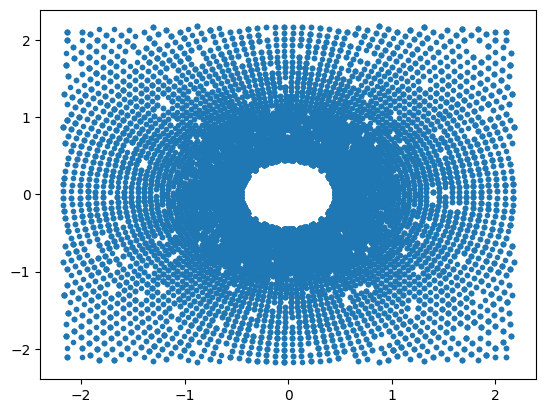

In [121]:
plt.scatter(X_train[:, 0], X_train[:, 1], marker = '.')

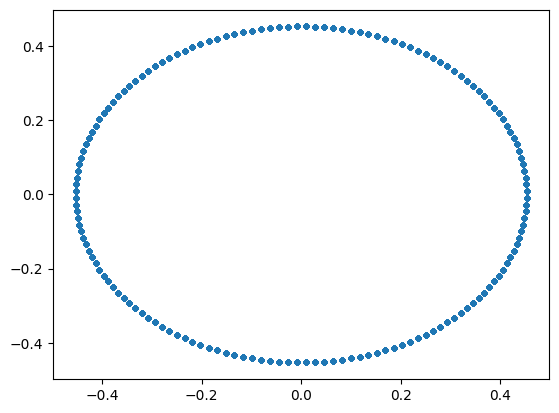

In [122]:
plt.scatter(X_border[:, 0], X_border[:, 1], marker = '.')

In [123]:
U_border[:, 0] *mean_std['u_std'] + mean_std['u_mean']

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [124]:
pressure = ((U_border[:, 2] *mean_std['p_std'] + mean_std['p_mean'])* ((param_adim["V"] ** 2) * param_adim["rho"])).numpy()

In [125]:
def true_cl(time_init, time_max):
    """
    Args:
        num (int): Le numéro du modèle
        case (int): Le numéro du case
        time_init (float): le temps initial 
        time_max (float): le temps max


    Returns:
        time (np.array):  les valeurs de temps
        cl (np.array): la valeur de cl à ces temps
    """
    df = pd.read_csv(f'results_Cl/model_2_case_2/Cl.csv', index_col=False)
    df_modified = df[((df.iloc[:, 2] > time_init) & (df.iloc[:, 2] < time_max))]
    time = df_modified.iloc[:, 2].to_numpy()
    cl = df_modified.iloc[:, 1].to_numpy()
    return time, cl

In [126]:
t = ((X_border[:, 2] * mean_std['t_std'] + mean_std['t_mean'])*(param_adim['L']/ param_adim['V'])).numpy()
x = ((X_border[:, 0] * mean_std['x_std'] + mean_std['x_mean'])*(param_adim['L'])).numpy()
y = ((X_border[:, 1] * mean_std['y_std'] + mean_std['y_mean'])*(param_adim['L'])).numpy()
pressure = ((U_border[:, 2] * mean_std['p_std'] + mean_std['p_mean']) * ((param_adim["V"] ** 2) * param_adim["rho"])).numpy()


In [127]:
r = 0.025
rho = 1.2
V = 1.

In [128]:
Cl = []
Time = []
for time_ in np.unique(t):
    masque_time = t == time_ 
    theta = np.arctan2(y[masque_time], x[masque_time])
    indice = np.argsort(theta)
    d_theta = theta[indice][1:] - theta[indice][:-1]
    f_portance = np.sum(-pressure[masque_time][indice][1:] * np.sin(theta[indice][1:]) * r * d_theta)
    portance= f_portance / (0.5 * rho * (V**2) * 2 * r)
    Time.append(t[masque_time][indice][0])
    Cl.append(portance)

In [129]:
time_true, cl_true = true_cl(t.min().item(), t.max().item())

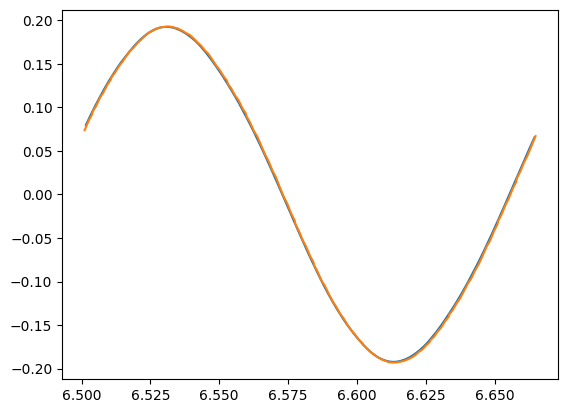

In [130]:
plt.plot(time_true, cl_true)
plt.plot(Time, Cl)

In [135]:
X_border.shape[0] * 0.9

18954.0

In [133]:
X_train.shape

torch.Size([18900, 5])

In [137]:
np.abs(theta).min()

np.float32(0.020138346)

In [139]:
1/np.sin(0.02)

np.float64(50.00333348889545)